# Federated Learning of U-Net for Pneumothorax Segmentation - Part 2

## Introduction

The notebook demonstrates how the same model can be trained by learning new parameters on each worker separately, and securely aggregating them at the end of each epoch using additive secret sharing.

We're using an example dataset from the [Pneumothorax Segmentation Kaggle competition](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation). 

## Imports

In [0]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split
from torchvision.transforms import Compose, Resize, ToTensor


# A few constants we'll be using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 256 # Input image size 
BATCH_SIZE = 2 # Batch size 
ROOT_DIR = './sample images/' # Input files folder
RLE_FILENAME = "train-rle-sample.csv" # Name of the file with masks
VAL_SPLIT = 0.4 # Part of the dataset used for validation

## Data Preprocessing

The data for the Pneumothorax competition is provided in the form of [Dicom](https://en.wikipedia.org/wiki/DICOMµ) files that contain images together with patient data and a CSV file with [RLE-encoded](https://en.wikipedia.org/wiki/Run-length_encoding) binary masks for each file. In `dataset.py` We've provided a custom PyTorch Dataset class that imports the Dicom files from the folder, decodes the RLE masks and returns the images and corresponding masks in the `PIL.Image` format. The transforms specified below resize the images and convert them to PyTorch tensors:

In [0]:
from dataset import SegmentationDataset

transforms = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
    ])


dataset = SegmentationDataset(ROOT_DIR, RLE_FILENAME,
                              input_transform=transforms,
                              target_transform=transforms
                             )

Next, we split it into two datasets for training and validation and create dataloaders. In real life, this data would be located at different hospitals, so we're going to distribute these datasets among the virtual workers later and pretend we never had access to them.

In [0]:
dataset_len = len(dataset)
val_len = int(np.floor(VAL_SPLIT * dataset_len))
train_len = dataset_len - val_len

dataset_train, dataset_val = random_split(dataset, [train_len, val_len])

dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size=BATCH_SIZE)

dataloader_val = torch.utils.data.DataLoader(dataset_val, 
                                             batch_size=BATCH_SIZE)

dataloaders = {
    "train": dataloader_train,
    "val": dataloader_val
}

## Explore the data

Here's what the imported data looks like: 

Batch 1
torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
Image 1


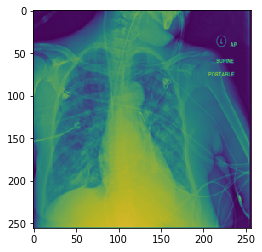

Image 2


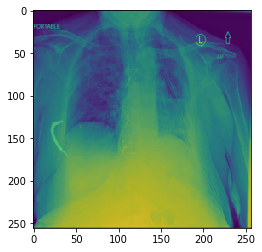

Batch 2
torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
Image 1


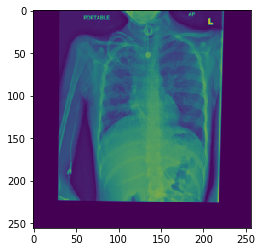

Image 2


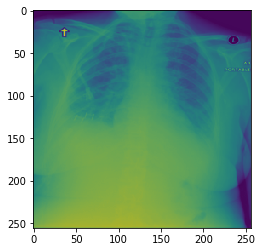

Batch 3
torch.Size([2, 3, 256, 256])
torch.Size([2, 1, 256, 256])
Image 1


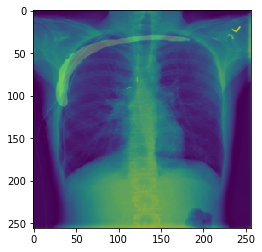

Image 2


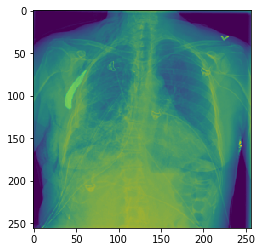

In [4]:
for i, (x, y) in enumerate(dataloader_train):
    print(f"Batch {i+1}")
    print(x.shape)
    print(y.shape)
    
    for image in range(dataloader_train.batch_size):
        print(f"Image {image+1}")
        plt.figure()
        plt.imshow(Image.fromarray(x[image][0,:,:].numpy()))
        plt.imshow(Image.fromarray(y[image][0,:,:].numpy()), alpha=0.2)
        plt.show()

## Model 

### U-Net Architecture

U-Net is a convolutional neural network developed for biomedical image segmentation by Olaf Ronneberger, Philipp Fischer, Thomas Brox in 2015 at the paper ["UNet: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597). It is based on Fully Convolutional Network architecture proposed by Evan Shelhamer, Jonathan Long, Trevor Darrellin their paper ["Fully convolutional networks for semantic segmentation"](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). Here's what the U-Net architecture looks like: 

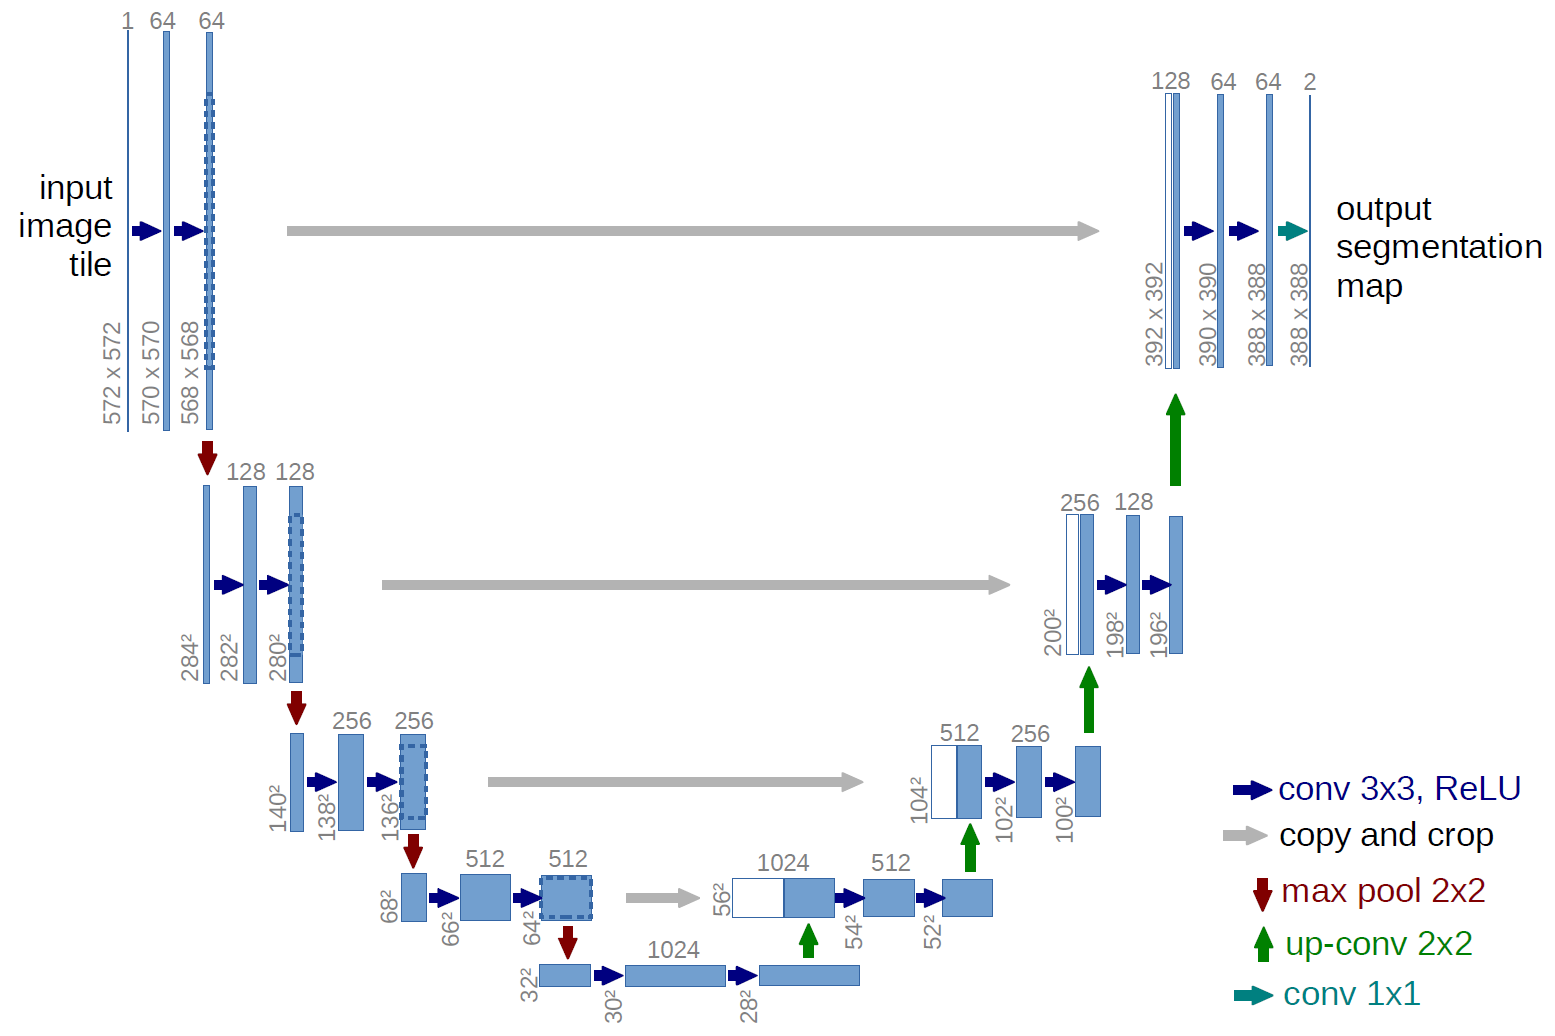

In [5]:
## image source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
from IPython.display import Image
Image("assets/u-net-architecture.png", width=700)

### Implementation
The implementation was taken from https://github.com/usuyama/pytorch-unet and can be found in the file `model.py` (and modified if needed):

In [0]:
from model import UNet

# We're predicting a one-channel mask for absence or presence of Pneumothorax 
channels_out = 1 
unet = UNet(channels_out).to(device)

### Functions used for loss calculation

Here we're using a weighted average of binary crossentropy loss and [Dice loss](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for backpropagation. We're reporting this loss, together with both Dice and binary crossentropy losses, as metrics during training.

In [0]:
# also pretty much inspired by https://github.com/usuyama/pytorch-unet

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (
        pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth
        )
    ))
    return loss.mean()


def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)   
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return bce, dice, loss


def update_metrics(metrics, bce, dice, loss, shape):
    metrics["bce"] += bce * shape
    metrics["dice"] += dice * shape
    metrics["loss"] += loss * shape
    return metrics


def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append(f"{k}: {metrics[k]/epoch_samples:4f}")
    print(f"{phase}: {', '.join(outputs)}")     

## Federated dataset 

## Federated dataset 

#### Hooking PyTorch and creating Virtual Workers

First we need to override the PyTorch methods so that we can execute commands on remote tensors as if they were on our local machine. This is done by running `hook = sy.TorchHook(torch)`. Then we create a number of VirtualWorkers, which are the entities that are actually located on our local server, but they can be used to simulate the behavior of remote workers: 

In [ ]:
import syft as sy  

hook = sy.TorchHook(torch)  
bob = sy.VirtualWorker(hook, id="bob") 
alice = sy.VirtualWorker(hook, id="alice")

# this is another worker that we'll use for the remote computation during training 
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

bob.add_workers([alice, secure_worker])
alice.add_workers([bob, secure_worker])
secure_worker.add_workers([alice, bob])

workers = (bob, alice)

workers_ids = {
    "bob": bob,
    "alice": alice
}

### Creating a federated dataset and a federated dataloader

We'll use the `dataset.federate()` method from PySyft here for demo purposes, but usually the datasets are already located on different clients. For this to be done, the dataset has to contain its data as the `.data` attribute, and its labels in the `.targets` attribute, so we need to tweak our train and validation datasets as follows: 

In [0]:
def reformat_subset_dataset(subset_dataset):
    subset_dataset.data = [subset_dataset.dataset[i][0] 
                           for i in subset_dataset.indices]
    subset_dataset.targets = [subset_dataset.dataset[i][1] 
                              for i in subset_dataset.indices]
    return subset_dataset

dataset_train = reformat_subset_dataset(dataset_train)
dataset_val = reformat_subset_dataset(dataset_val)

federated_dataset_train = dataset_train.federate(workers)
federated_dataset_val = dataset_val.federate(workers)

federated_train_loader = sy.FederatedDataLoader(federated_dataset_train, 
                                                batch_size=BATCH_SIZE
                                                )

federated_val_loader = sy.FederatedDataLoader(federated_dataset_val, 
                                              batch_size=BATCH_SIZE
                                              )

dataloaders = {
    "train": federated_train_loader,
    "val": federated_val_loader
}

## Federated training with secure aggregation 


Below is the training function that we'll use to train our model. It is different from the one we used in the previous notebook, because instead of sending the model to each worker every time, we train instead a separate model and then average the parameters after each epoch using the mechanism called [Secure Multi-Party Computation](https://en.wikipedia.org/wiki/Secure_multi-party_computation), which performs secure mathematical operations on tensors that are encrypted by splitting them in shares and distributing across multiple workers, so that each of them holds a share of a tensor, but is unable to infer what the actual value of that tensor is. This technique is called Additive Secret Sharing, and you can learn more about it in [this excellent blog](https://mortendahl.github.io/2017/06/04/secret-sharing-part1/). 

Let's see how this works in practice using PySyft:

In [0]:
def train_model(model, lr=0.01, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    bce_weight = 0.5

    n_params = len(list(model.parameters()))
    
    # copy the model to each worker
    workers_models = {}
    for worker in workers:
        workers_models[worker.id] = model.copy().send(worker)
    
    # a dict with each models' parameters
    workers_params = {}
    for worker in workers:
        workers_params[worker.id] = list(workers_models[worker.id].parameters())

    # we need a separate optimizer for each of the models 
    workers_optimizers = {}
    for worker in workers:
        workers_optimizers[worker.id] = optim.SGD(workers_params[worker.id], lr)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        since = time.time()
        
        for phase in ['train', 'val']: 
            if phase == 'train': 
                # set model to training mode
                model.train()  
            else:
                model.eval()  
                
            # We'll store metrics here    
            metrics = defaultdict(float)
            epoch_samples = 0
            
            # For each batch in the current dataloader
            for data, target in dataloaders[phase]:
                # pick the model and the optimizer 
                # that correspond to the current worker
                
                worker_id = data.location.id
                worker_model = workers_models[worker_id]
                optimizer = workers_optimizers[worker_id]
                
                data, target = data.to(device), target.to(device)
                
                # Forward prop
                optimizer.zero_grad()
                output = worker_model(data)
                bce, dice, loss = calc_loss(output, target)
                
                # Backprop only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                # Update the metrics for the current epoch
                metrics = update_metrics(metrics, 
                                     bce.get().item(), 
                                     dice.get().item(), 
                                     loss.get().item(), 
                                     target.shape[0])
                epoch_samples += data.shape[0]
                
            # After each phase print the metrics      
            print_metrics(metrics, epoch_samples, phase)
   
        # After each epoch    
        time_elapsed = time.time() - since
        print(f'{time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

        print("Aggregating...")
        
        # Calculate new params using the Secure Multi Party Computation :
        new_params = []
        
        # for each parameter
        for param_i in range(n_params): 
            spdz_params = []
            
            for worker in workers:
                # copy the parameters 
                copy_of_parameter = workers_params[worker.id][param_i].copy()
                # convert them to fix precision vectors 
                # this is used to represent the decimals as integer values
                fixed_prec_param = copy_of_parameter.cpu().fix_prec()
                
                # Now that we have the tensors in the integer form,
                # we can share them across all workers using the additive secret sharing;
                
                encrypted_param = fixed_prec_param.share(*workers, 
                                                         crypto_provider=secure_worker)
                # The crypto_provider argument allows us to specify the worker 
                # that will provide the cryptographic primitives for the 
                # secure computation using the SPDZ protocol 
                # (https://mortendahl.github.io/2017/09/03/the-spdz-protocol-part1/)
                
                # Now each worker's parameters are stored across all workers 
                # in the form of AdditiveSharingTensors
                # without any of them knowing what's inside!
                
                param = encrypted_param.get()
                spdz_params.append(param)
            
            # The properties of these tensors are such that we
            # can perform arithmetic operations on them, such as the sum operation:
            # (this is called the homomorphic property: 
            # https://en.wikipedia.org/wiki/Homomorphic_encryption)
            new_param = sum(spdz_params).get().float_prec()/len(workers)
            
            # This allows us to aggregate the model parameters without having to 
            # consolidate all the parameter tensors on one server!
            new_params.append(new_param.cuda())

        # Now we update all the workers' models with the new parameters and
        # continue to the next epoch 
        print("Updating workers' models...")
        with torch.no_grad():
            for worker in workers:
                for param in workers_params[worker.id]:
                    param *= 0
                workers_models[worker.id].get()
                for param_i in range(n_params):
                    workers_params[worker.id][param_i].set_(new_params[param_i])
                workers_models[worker.id] = workers_models[worker.id].send(worker)
        
    # At the end of the training, get the latest model from one of the workers
    print("Retrieving the final model...")
    model = list(workers_models.values())[0].get()
    print("Success!")
    return model

#### Now everything is ready for training! 

In [11]:
model = train_model(unet, lr=0.01, num_epochs=10)

Epoch 1/10
----------
train: bce: 0.674731, dice: 0.988787, loss: 0.831759
val: bce: 0.671813, dice: 0.994576, loss: 0.833194
0m 1s
Aggregating...
Updating workers' models...
Epoch 2/10
----------
train: bce: 0.671534, dice: 0.988790, loss: 0.830162
val: bce: 0.668640, dice: 0.994576, loss: 0.831608
0m 1s
Aggregating...
Updating workers' models...
Epoch 3/10
----------
train: bce: 0.657172, dice: 0.988807, loss: 0.822990
val: bce: 0.653766, dice: 0.994587, loss: 0.824177
0m 1s
Aggregating...
Updating workers' models...
Epoch 4/10
----------
train: bce: 0.640830, dice: 0.988823, loss: 0.814826
val: bce: 0.636306, dice: 0.994600, loss: 0.815453
0m 1s
Aggregating...
Updating workers' models...
Epoch 5/10
----------
train: bce: 0.548451, dice: 0.988981, loss: 0.768716
val: bce: 0.517046, dice: 0.994728, loss: 0.755887
0m 1s
Aggregating...
Updating workers' models...
Epoch 6/10
----------
train: bce: 0.052735, dice: 0.997788, loss: 0.525261
val: bce: 0.033028, dice: 0.998308, loss: 0.515668

#### That's it! Now the model can be tested on new data, or trained further!